#  CBC/RD activation model
Joep van Schelven - 2025 

This model is aimed to simulate different activation strategies of Capacity limitng contracts (CLC/CBC) and redispatch contracts. The main goal is to effectively mitigate congestion against optimal costs.


### import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import os  

#this is a custom script used to plot different networks
from network_plotting import draw_network, draw_network_with_power_flows, draw_network_with_absolute_power_flows, draw_network_with_congestion




### Load variables and input data
The input data needs to be a seperate Excel with specified lay-out

note: generation is negative and load is positive

In [2]:
from config_loader import retrieve_config_variables

# Retrieve variables as a tuple, use this line in sperate files to get teh same gloabl variables
ptus, input_file, susceptance, df_lines, buses, n_buses, n_lines, ratio = retrieve_config_variables()

df_loads_D2 = pd.read_excel(input_file,'loads', header=0, index_col=0)  #load D-2 prognoses for loads
df_RE_D2 = pd.read_excel(input_file,'re', header=0, index_col=0)        #Load D-2 prognoses for renewable generation
df_chp_max = pd.read_excel(input_file,'chp_max', header=0, index_col=0) #Load the maximum power output of CHPs


### DC load-flow
First, we will use the the D-2 prognoses to perform a 'manual' DC load-flow. This load-flow will be used to visualise the network behaviour nd see where the congestion occurs. 

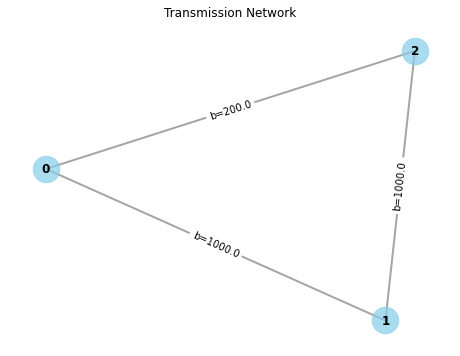

In [3]:
#Make a matrix where every node and every ptu have total load excluding CHP generation
load_per_node_D2 = np.zeros((n_buses,ptus))

# This is afunction to add the values of one DF to another array, based on the nodes provided in the DF
def add_to_array(df_in: pd.DataFrame, np_out: np.array) -> np.array:
    for idx, row in df_in.iterrows():  # Iterate over DataFrame rows
        node = row["node"]  # Use the "node" column explicitly
        if node in buses:  # Check if the node is in the buses list
            bus_idx = buses.index(node)  # Get the index of the node in the buses list
            values = row[1:].to_numpy(dtype=float)  # Convert the remaining columns to a NumPy array
            np_out[bus_idx, :] += values  # Add values to the corresponding row in np_out
    return np_out

# use the function to add RE and load profiels to the load per node
load_per_node_D2 = add_to_array(df_RE_D2, load_per_node_D2)
load_per_node_D2 = add_to_array(df_loads_D2, load_per_node_D2)

#This is a function that identifies the imbalnce at every PTU and dispatches the CHPs to balance the system
    # The CHPs are dispatched in order, to mimic a merit order (highset = cheapest)
    
def CHP_dispatch_calc(df_chp_max: pd.DataFrame, load_per_node:pd.DataFrame) -> pd.DataFrame:
    # Initialize an array for CHP dispatch
    chp_dispatch = np.zeros((len(df_chp_max), ptus))
    #find total imbalance per ptu this is the power the chp_maxS have to deliver for a balanced grid
    imbalance_per_ptu = load_per_node.sum(axis=0)
    # Calculate power required per ptu
    p_chp_required = -imbalance_per_ptu
    
    # Loop over each PTU
    for t in range(ptus):
        p = p_chp_required[t]
        chp = 0
    
        # Balance the power for this PTU
        while p < 0 and chp < len(df_chp_max):  # Ensure we don't exceed available CHPs
            max_dispatch = df_chp_max.iloc[chp, 1]  # Maximum dispatch capacity for this CHP
            
            if abs(p) <= abs(max_dispatch):  # If the current CHP can fully balance the power
                chp_dispatch[chp, t] = p
                p = 0  # Fully balanced
            else:  # Dispatch as much as possible from the current CHP
                chp_dispatch[chp, t] = max_dispatch
                p -= max_dispatch  # Remaining imbalance
                chp += 1  # Move to the next CHP
    
        p_chp_required[t] = p  # Update remaining imbalance for this PTU (should not become positive)
    
    #make a DF where the location of the CHPs is also included
    chp = pd.DataFrame(chp_dispatch)
    chp.insert(0, 'node', df_chp_max.iloc[:,0])
    return chp

#use both function to add the CHP to the load per node.
chp = CHP_dispatch_calc(df_chp_max, load_per_node_D2)
load_per_node_D2 = add_to_array(chp, load_per_node_D2)

# check if the system is balanced, exit the script if not the case
if load_per_node_D2.sum() != 0:
    fig, ax = plt.subplots()
    pd. DataFrame(load_per_node_D2.sum(axis = 0)).plot(ax=ax)
    ax.set_xlabel("Hour on day D")
    ax.set_ylabel("Unbalance [MW]")
    ax.set_title("Unbalance per hour ")
    if load_per_node_D2.sum() > 0:
        sys.exit(f' The system is inherently unbalanced because too little generation. {load_per_node_D2.sum()} MWh additional generation is required is required.')
    elif load_per_node_D2.sum < 0:
        sys.exit(f' The system is inherently unbalanced because to much RE. {load_per_node_D2.sum()} MWh "curtailement" is required.')

    
#build the susceptance matrix
df_lines['susceptance'] = 1/(df_lines['len']*(1/susceptance))
B = np.zeros((n_buses, n_buses))

for _, row in df_lines.iterrows():
    from_idx = buses.index(row['from_bus'])
    to_idx = buses.index(row['to_bus'])
    B[from_idx, to_idx] -= row['susceptance']
    B[to_idx, from_idx] -= row['susceptance']
    B[from_idx, from_idx] += row['susceptance']
    B[to_idx, to_idx] += row['susceptance']
    
    
#define a function to calculate the powerflows according to DC powerflow apporach
def calculate_powerflow(df_loads_D2: np.array) -> pd.DataFrame:
    # Initialize results df
    df_results = pd.DataFrame({'flow': n_lines * [0.0]}, index=df_lines.index)

    slack_bus = 0 # note: because system is always balanced a slackbus is not nescsary and it does nt matter wich bus you define
    B_reduced = np.delete(B, slack_bus, axis=0)
    B_reduced = np.delete(B_reduced, slack_bus, axis=1)

    # Adjust the load vector to exclude the slack bus
    load_reduced = np.delete(df_loads_D2, slack_bus, 0)

    # Solve for the phase angles (theta) at the non-slack buses
    theta_reduced = np.linalg.solve(B_reduced, load_reduced)

    # Reconstruct the full theta vector including the slack bus (assumed 0 phase angle)
    theta = np.zeros(n_buses)
    theta[1:] = theta_reduced

    # Calculate line flows    
    df_results['flow'] = [
        row['susceptance'] * (theta[buses.index(row['from_bus'])] - theta[buses.index(row['to_bus'])])
        if row['from_bus'] in buses and row['to_bus'] in buses else 0
        for _, row in df_lines.iterrows()
    ]
    return df_results

#use function to create a DF with all the flows per line 

df_flows = pd.DataFrame(columns = range(ptus))
for t in range(ptus):
    df_flows[t] = calculate_powerflow(load_per_node_D2[:,t])

#draw your network
draw_network(df_lines)

### Localise and deterimine congestion volume
Use the flow DF and the capacity of the lines to find the congestion

In [4]:
# initieer een DF voor alle overloads
df_congestion = pd.DataFrame(index=df_lines.index, columns = range(ptus))

# definieer een functie die de overload kan bereken aan de hand van line capacity en flows
def overload_calculation(df_flows : pd.DataFrame) -> pd.DataFrame:
    for line in df_congestion.index:  # Iterate over line indices
        for t in range(ptus):  # Iterate over PTUs (time steps)
            overload = abs(df_flows.iloc[line,t]) - df_lines['capacity'].loc[line]
            if overload > 0:
                df_congestion.iloc[line, t] = float(overload)
            else:
                df_congestion.iloc[line, t] = 0
    return df_congestion

df_congestion = overload_calculation(df_flows)
congestion_D2 = sum(df_congestion.sum())

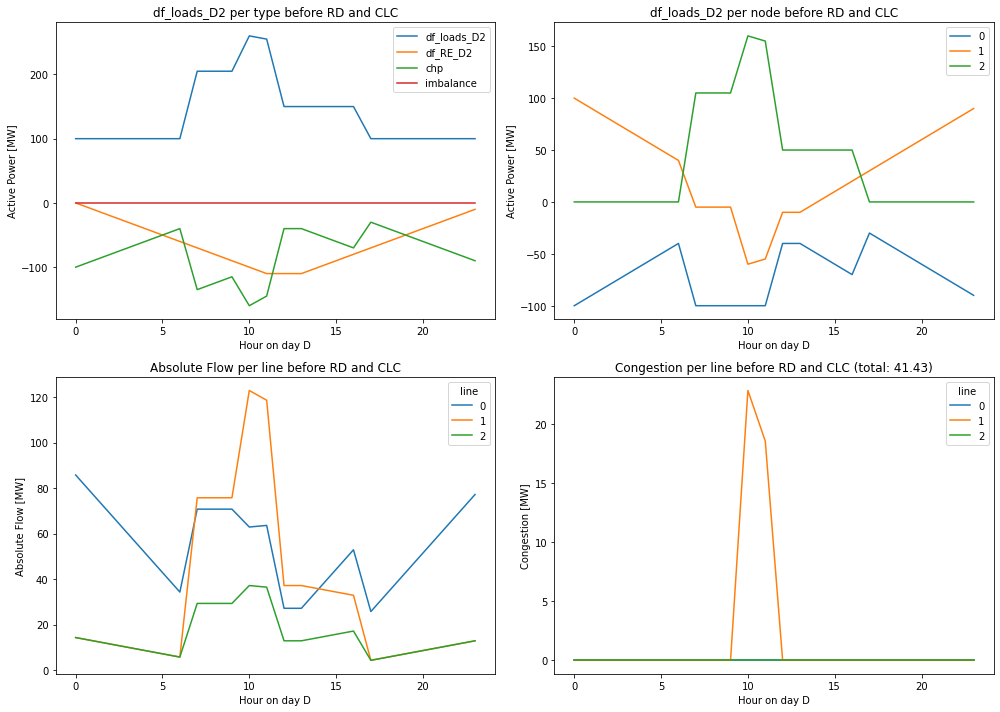

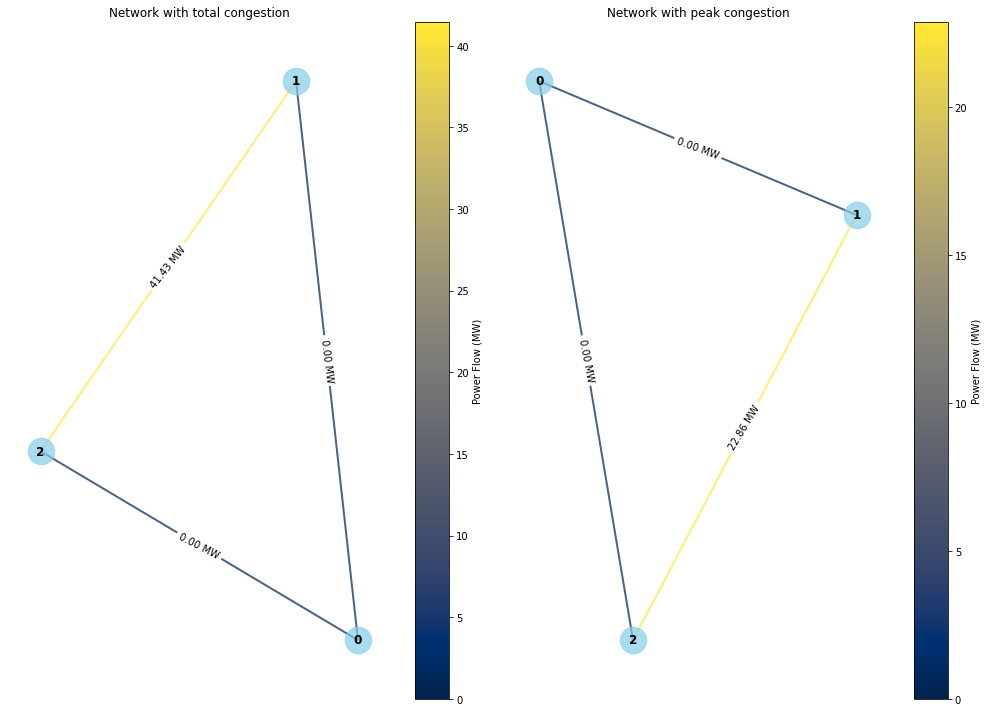

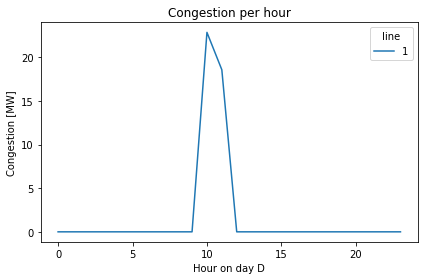

System is congested, proceed to CBC activation


In [5]:
#%% Visualization of generation per type and per node of the d-2 prognoses

#make a dict with all the load per generation type
load_per_type = {'df_loads_D2': ptus * [0], 'df_RE_D2': ptus * [0], 'chp': ptus * [0]}
for key in load_per_type.keys():
    load_per_type[key] = globals()[key].iloc[:,1:].sum()
    
load_per_type = pd.DataFrame(load_per_type)
load_per_type['imbalance'] = load_per_type.sum(axis=1)


# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot 1: df_loads_D2 per type before RD and CLC
load_per_type.plot(ax=axes[0, 0])
axes[0, 0].set_xlabel("Hour on day D")
axes[0, 0].set_ylabel("Active Power [MW]")
axes[0, 0].set_title("df_loads_D2 per type before RD and CLC")

# Plot 2: df_loads_D2 per node before RD and CLC
pd.DataFrame(load_per_node_D2).T.plot(ax=axes[0, 1])
axes[0, 1].set_xlabel("Hour on day D")
axes[0, 1].set_ylabel("Active Power [MW]")
axes[0, 1].set_title("df_loads_D2 per node before RD and CLC")

# Plot 3: absolute flow per line before RD and CLC
pd.DataFrame(abs(df_flows)).T.plot(ax=axes[1, 0])
axes[1, 0].set_xlabel("Hour on day D")
axes[1, 0].set_ylabel("Absolute Flow [MW]")
axes[1, 0].set_title("Absolute Flow per line before RD and CLC")

# Plot 4: Congestion per line before RD and CLC
pd.DataFrame(df_congestion).T.plot(ax=axes[1, 1])
axes[1, 1].set_xlabel("Hour on day D")
axes[1, 1].set_ylabel("Congestion [MW]")
axes[1, 1].set_title(f"Congestion per line before RD and CLC (total: {round(congestion_D2, 2)})")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Create 2x1 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))

# Plot 1: Network with total congestion
congestion_per_bus = df_congestion.sum(axis='columns')
congestion_per_bus = congestion_per_bus.rename_axis('line').reset_index(name='flow')
draw_network_with_power_flows(df_lines, congestion_per_bus, 'Network with total congestion', axes[0])

# Plot 2: Network with peak congestion
congestion_peak_per_bus = df_congestion.max(axis='columns')
congestion_peak_per_bus = congestion_peak_per_bus.rename_axis('line').reset_index(name='flow')
draw_network_with_power_flows(df_lines, congestion_peak_per_bus, 'Network with peak congestion', axes[1])

plt.tight_layout()
plt.show()

# Plot 3: Congestion per hour
fig, ax = plt.subplots()
df_congestion[df_congestion.sum(axis=1) != 0].transpose().plot(ax=ax)
ax.set_xlabel("Hour on day D")
ax.set_ylabel("Congestion [MW]")
ax.set_title("Congestion per hour")



# Adjust layout
plt.tight_layout()
plt.show()

#check if there is congstion in the system
if congestion_D2 == 0:
    sys.exit('No congestion is the system')
else:
    print('System is congested, proceed to CBC activation')


### Activate CBCs
Het Idee is dat eerst CBCs worden afgeroepen (optimalisereend voor de kosten en het congestievolume terugdringend naar een bepaald niveau).
Vervolgens word er weer gedispatched met als constraint dat he tcongestievolume niet mag toenemen

In [6]:
df_CBC_orderbook = pd.read_excel(input_file,'CBC', header=0, index_col=0) #read the orderbook

from CBC import optimal_CBC

model = optimal_CBC(load_per_node_D2, df_CBC_orderbook,sum(df_congestion.sum()),0)

# Get results from the model
p_CBC = {(b, t): pyo.value(model.dp[b, t]) for b in model.bus_set for t in model.time_set}
congestion_hypotheses_CBC = {(l, t): pyo.value(model.congestion[l, t]) for l in model.line_set for t in model.time_set}

total_congestion_results = pyo.value(model.total_congestion)
total_costs_results = pyo.value(model.total_costs)


# Create a DataFrame from the dictionary
df_dp_CBC = pd.DataFrame.from_dict(p_CBC, orient='index', columns=['value'])
# Reset the index and expand the tuple keys into separate columns
df_dp_CBC.index = pd.MultiIndex.from_tuples(df_dp_CBC.index, names=["node", "hour"])
df_dp_CBC = df_dp_CBC.unstack(level="hour")

# Clean up the column names
df_dp_CBC.columns = df_dp_CBC.columns.droplevel(0)
df_dp_CBC = df_dp_CBC.reset_index()


# Transform the dictionary into a DataFrame
df_congestion_hypotheses_CBC = pd.DataFrame.from_dict(congestion_hypotheses_CBC, orient="index", columns=["congestion"])
# Reset the index and expand the tuple keys into separate columns
df_congestion_hypotheses_CBC.index = pd.MultiIndex.from_tuples(df_congestion_hypotheses_CBC.index, names=["node", "hour"])
df_congestion_hypotheses_CBC = df_congestion_hypotheses_CBC.unstack(level="hour")
# Clean up the column names
df_congestion_hypotheses_CBC.columns = df_congestion_hypotheses_CBC.columns.droplevel(0)


tot_congestion_hypotheses_CBC = sum(df_congestion_hypotheses_CBC.sum())
ratio_hypothesis = tot_congestion_hypotheses_CBC/congestion_D2
print(f'The aimed congestion reduction is {ratio}, the actual ongestion redution is {1-ratio_hypothesis}')

#add CBC result to load array
add_to_array(df_dp_CBC, load_per_node_D2)


Termination condition: optimal
78300.0
congestion volume X avg_Price = 4.142857142857143 X 400.0 = 1657.1428571428573
total costs are 78300.0
The aimed congestion reduction is 0.9, the actual ongestion redution is 0.9


array([[-100.  ,  -90.  ,  -80.  ,  -70.  ,  -60.  ,  -50.  ,  -40.  ,
        -100.  , -100.  , -100.  ,   20.  ,  -24.25,  -40.  ,  -40.  ,
         -50.  ,  -60.  ,  -70.  ,  -30.  ,  -40.  ,  -50.  ,  -60.  ,
         -70.  ,  -80.  ,  -90.  ],
       [ 100.  ,   90.  ,   80.  ,   70.  ,   60.  ,   50.  ,   40.  ,
          -5.  ,   -5.  ,   -5.  ,  -60.  ,  -55.  ,  -10.  ,  -10.  ,
           0.  ,   10.  ,   20.  ,   30.  ,   40.  ,   50.  ,   60.  ,
          70.  ,   80.  ,   90.  ],
       [   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
         105.  ,  105.  ,  105.  ,  160.  ,  155.  ,   50.  ,   50.  ,
          50.  ,   50.  ,   50.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ]])

### Actualise prognoses
Introduce 'noise' to the prognoses so they represent the actual T-pofile data to be used for the marketcoupling later the CBC will also be taken into consoderation during this stage, but not yet implemented

In [7]:

def add_normal_noise(df_D2 : pd.DataFrame, std : int) -> pd.DataFrame: #function to add normal noise to with provided STD DF with specific shape (mean=0) Only adds noise to non-zero values
    df_output = df_D2.copy()
    for load in range(len(df_D2)):
        noise = np.random.normal(0, std, (df_D2.columns != 'node').sum())
        noise = np.trunc(noise * 10**2) / 10**2
        df_output.iloc[load,1:] += (df_output.iloc[load, 1:] != 0) * noise
    return df_output

# add noise to the D-2 to make 'actual' data. use these to make new load per node, and new CHP dispatch (marketcoupling). Results in a new load per node and new congestion 
df_loads = add_normal_noise(df_loads_D2, 0)
df_RE    = add_normal_noise(df_RE_D2, 0)

load_per_node = np.zeros((n_buses,ptus))
load_per_node = add_to_array(df_RE, load_per_node)
load_per_node = add_to_array(df_loads, load_per_node)
load_per_node = add_to_array(df_dp_CBC, load_per_node)


chp_coupling = CHP_dispatch_calc(df_chp_max, load_per_node)
#find total load per node per CHP 

load_per_node = add_to_array(chp_coupling, load_per_node)

Balanced market coupling succesful, load flow calculation will be performed


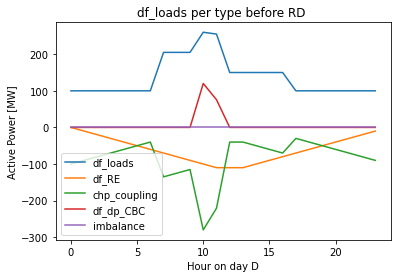

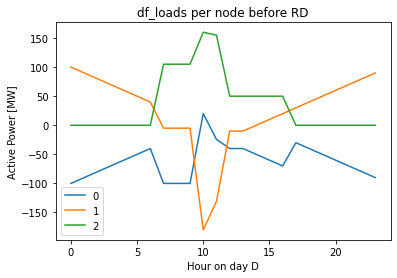

In [8]:
#%% Vsualization of generation per type and per node before RD

#make a dict with all the load per generation type
load_per_type = {'df_loads': ptus * [0], 'df_RE': ptus * [0], 'chp_coupling': ptus * [0], 'df_dp_CBC': ptus * [0]}
for key in load_per_type.keys():
    load_per_type[key] = globals()[key].iloc[:,1:].sum()
    
load_per_type = pd.DataFrame(load_per_type)
load_per_type['imbalance'] = load_per_type.sum(axis=1)


fig, ax = plt.subplots()
load_per_type.plot(ax=ax)
ax.set_xlabel("Hour on day D")
ax.set_ylabel("Active Power [MW]")
ax.set_title("df_loads per type before RD ")

fig, ax = plt.subplots()
pd.DataFrame(load_per_node).T.plot(ax=ax)
ax.set_xlabel("Hour on day D")
ax.set_ylabel("Active Power [MW]")
ax.set_title("df_loads per node before RD")

# Truncate load_per_node after the th decimal
scaling_factor = 10**6
load_per_node = np.trunc(load_per_node * scaling_factor) / scaling_factor
# check if the system is balanced, exit the script if not the case
if load_per_node.sum() != 0:
    fig, ax = plt.subplots()
    pd. DataFrame(load_per_node_D2.sum(axis = 0)).plot(ax=ax)
    ax.set_xlabel("Hour on day D")
    ax.set_ylabel("Unbalance [MW]")
    ax.set_title("Unbalance per hour ")
    if load_per_node.sum() > 0:
        sys.exit(f' The system is inherently unbalanced because too little generation after CBC activation {load_per_node.sum()} MWh additional generation is required is required.')
    elif load_per_node.sum() < 0:
        sys.exit(f' The system is inherently unbalanced because to much RE after CBC activation. {load_per_node.sum()} MWh "curtailement" is required.')
else:
    print('Balanced market coupling succesful, load flow calculation will be performed')



### Redispatch
Using Pyomo, and load-flow constraints, dispatch the optimal set of bids to minimze costs and mitigate any remaining congestion. 
Input shouldbe a balanced DF wih load per node per ptu

In [9]:
#Fist initlialize dicts (pyomo works with dicts)
df_RD_orderbook = pd.read_excel(input_file,'RD', header=0, index_col=0) #read the orderbook

from redispatch import optimal_redispatch

model = optimal_redispatch(load_per_node, df_RD_orderbook,0)

Termination condition: optimal
35123.0
congestion volume X avg_Price = 0.0 X 300.0 = 0.0
total costs are 35123.0


In [10]:
# Get results from the model
dp_results = {(b, t): pyo.value(model.dp[b, t]) for b in model.bus_set for t in model.time_set}
f_results = {(l, t): pyo.value(model.f[l, t]) for l in model.line_set for t in model.time_set}
congestion_results = {(l, t): pyo.value(model.congestion[l, t]) for l in model.line_set for t in model.time_set}

total_congestion_results = pyo.value(model.total_congestion)
total_costs_results = pyo.value(model.total_costs)




# Create a DataFrame from the dictionary
result_df_dp = pd.DataFrame.from_dict(dp_results, orient='index', columns=['value'])
result_df_f = pd.DataFrame.from_dict(f_results, orient='index', columns=['value'])
result_df_congestion = pd.DataFrame.from_dict(congestion_results, orient='index', columns=['value'])

In [11]:
print(input_file)

3_bus_input.xlsx
